<CENTER><img src="../images/ATLASOD.gif" style="width:50%"></CENTER>

# <CENTER><h1> Two $\tau$-lepton final state: the case of SM Z boson production

This notebook provides the analysis of Z boson decaying into two $\tau$ leptons, one of them decaying hadronically and the other one decaying leptonically in the final state. The leptonic decay of the $\tau$ lepton produces a light lepton such as an electron or muon, with a neutrino and antineutrino $(\tau_l \rightarrow l \nu \bar{\nu})$ which are considered by the missing transverse energy of each event. The hadronic decay of the $\tau$ lepton produces a highly collimated jet in the detector consisting of charged hadrons and possibly additional deposits of energy in calorimeters from neutral decays products $(\tau_h \rightarrow hadrons \ \nu)$. (For further information, see [ATLAS documentation 13 TeV](https://cds.cern.ch/record/2707171/files/ANA-OTRC-2019-01-PUB-updated.pdf) and look for the 3.10 section).

The selection criteria we are going to use requires we have into account at least three main sources of background :
* $Z \rightarrow ee, \mu \mu$: The Z boson decaying into two light leptons.
* $W+jets$: Which consider a lepton (electron or muon) with neutrinos and jets in the final state.
* $Others$: Which consider $t \bar{t}$, single top, DY and diboson processes with jets and leptons in final state 

Our signal is the processes $Z \rightarrow \tau \tau$ with hadronic and leptonic decays of the $\tau$ leptons, and the idea is to compare Data with MC samples once we have applied all cuts at the end of the analysis and see how MC samples match with the selected data.

At the end of this analysis, you will be able to get plots with the missing transverse energy $E_{T}^{miss}$, the visible mass of the $\tau$ lepton and the light lepton system, and the transverse mass calculated from the light lepton and the missing transverse energy system, all of them having into account the contribution of MC samples (a stacked plot). Here you can find many tools to perform the desired selection of events, how to declare histograms, variables, read ROOT files and so on.

The Feynman diagram of our process can be shown below:

$Z \rightarrow \tau_{l} \tau_{h}$
![Z tau tau](../images/ztautau.png)

The Analysis is implemented by using some useful tools, such as `pandas` (to storage dataframes), `numpy` (the numerical library of python), `uproot3` (to read root files), `matplotlib` (to plot our graphics) and `math` library (an additional library in python that allows you to use numerical functions).

First of all, we should verify that we have installed all the needed tools to perform our analysis. If we haven't, we can run the next code line:

In [1]:
import sys
!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer
!{sys.executable} -m pip install -U numpy pandas uproot3 matplotlib --user # install required packages

'\nimport sys\n!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer\n!{sys.executable} -m pip install -U numpy pandas uproot3 matplotlib --user # install required packages\n'

Now, we can import the tools that we are going to use (pandas, numpy, matplotlib, etc):

In [2]:
import pandas as pd # to store data as dataframes
import numpy as np # for numerical calculations such as histogramming
import math # for mathematical functions such as square root
import uproot3 # to read .root files as dataframes
import time # to measure time to analyse
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import infofile # local file containing info on cross-sections, sums of weights, dataset IDs

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


The root files which contain the events information are stored in the [1lep1tau folder](https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/1lep1tau/). So we are going to define the **path_file** variable which contains the url of the folder uploaded in the ATLAS Open Data repository on the cloud. The next code line also defines a variable named **lumi**, which represents the luminosity and it is equal to 10 $fb^{-1}$. If we want to run the analysis over a fraction of the whole data and MC samples, we can define another variable named **fraction**, which will be defined equal to 1.0 as default. However, you can change this fraction value and see how this can affect the final result shown in the final plots:

In [3]:
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

fraction = 1.0 # reduce this is if you want the code to run quicker
                                                                                                                                  
#tuple_path = "Input/4lep/" # local 
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/1lep1tau/" # web address

Now, we are going to make a list named **samples**. In this samples list we are going to include data and background samples (including the signal we want to observe). In the next code line we can see all samples that are going to be used in the analysis and to what group they belong. If you want to add more samples, consider modifying this code line too. 

In [4]:
samples = {

    'data': {
        'list' : ['data_A','data_B','data_C','data_D'],
    },

    
    r'Other' : { #
        'list' : ['llll', 'lllv', 'llvv', 'lvvv', 'ZqqZll','WqqZll','WpqqWmlv', 'WplvWmqq', 'WlvZqq', 
                  'single_top_tchan','single_antitop_tchan','single_top_schan','single_antitop_schan',
                  'single_top_wtchan','single_antitop_wtchan','ttbar_lep'],
        'color' : "#6b59d3" # purple
    },

    r'$W+$jets' : { #
        'list' : ['Wmunu_PTV0_70_CVetoBVeto', 'Wmunu_PTV0_70_CFilterBVeto', 'Wmunu_PTV0_70_BFilter',
                 'Wmunu_PTV70_140_CVetoBVeto', 'Wmunu_PTV70_140_CFilterBVeto', 'Wmunu_PTV70_140_BFilter',
                 'Wmunu_PTV140_280_CVetoBVeto', 'Wmunu_PTV140_280_CFilterBVeto', 'Wmunu_PTV140_280_BFilter',
                 'Wmunu_PTV280_500_CVetoBVeto', 'Wmunu_PTV280_500_CFilterBVeto', 'Wmunu_PTV280_500_BFilter',
                 'Wmunu_PTV500_1000', 'Wmunu_PTV1000_E_CMS', 'Wenu_PTV0_70_CVetoBVeto', 'Wenu_PTV0_70_CFilterBVeto',
                 'Wenu_PTV0_70_BFilter', 'Wenu_PTV70_140_CVetoBVeto', 'Wenu_PTV70_140_CFilterBVeto',
                 'Wenu_PTV70_140_BFilter', 'Wenu_PTV140_280_CVetoBVeto', 'Wenu_PTV140_280_CFilterBVeto',
                 'Wenu_PTV140_280_BFilter', 'Wenu_PTV280_500_CVetoBVeto', 'Wenu_PTV280_500_CFilterBVeto',
                 'Wenu_PTV280_500_BFilter', 'Wenu_PTV500_1000', 'Wenu_PTV1000_E_CMS', 'Wtaunu_PTV0_70_CVetoBVeto',
                 'Wtaunu_PTV0_70_CFilterBVeto', 'Wtaunu_PTV0_70_BFilter', 'Wtaunu_PTV70_140_CVetoBVeto',
                 'Wtaunu_PTV70_140_CFilterBVeto', 'Wtaunu_PTV70_140_BFilter', 'Wtaunu_PTV140_280_CVetoBVeto',
                 'Wtaunu_PTV140_280_CFilterBVeto', 'Wtaunu_PTV140_280_BFilter', 'Wtaunu_PTV280_500_CVetoBVeto',
                 'Wtaunu_PTV280_500_CFilterBVeto', 'Wtaunu_PTV280_500_BFilter', 'Wtaunu_PTV500_1000',
                 'Wtaunu_PTV1000_E_CMS'],
        'color' : "#00ff84" # ligth green
    },
    
    
    r' $Z \rightarrow ee, \mu \mu$' : { #
        'list' : ['Zmumu_PTV0_70_CVetoBVeto', 'Zmumu_PTV0_70_CFilterBVeto', 'Zmumu_PTV0_70_BFilter',
                 'Zmumu_PTV70_140_CVetoBVeto', 'Zmumu_PTV70_140_CFilterBVeto', 'Zmumu_PTV70_140_BFilter',
                 'Zmumu_PTV140_280_CVetoBVeto', 'Zmumu_PTV140_280_CFilterBVeto', 'Zmumu_PTV140_280_BFilter',
                 'Zmumu_PTV280_500_CVetoBVeto', 'Zmumu_PTV280_500_CFilterBVeto', 'Zmumu_PTV280_500_BFilter',
                 'Zmumu_PTV500_1000', 'Zmumu_PTV1000_E_CMS', 'Zee_PTV0_70_CVetoBVeto', 'Zee_PTV0_70_CFilterBVeto',
                 'Zee_PTV0_70_BFilter', 'Zee_PTV70_140_CVetoBVeto', 'Zee_PTV70_140_CFilterBVeto',
                 'Zee_PTV70_140_BFilter', 'Zee_PTV140_280_CVetoBVeto', 'Zee_PTV140_280_CFilterBVeto',
                 'Zee_PTV140_280_BFilter', 'Zee_PTV280_500_CVetoBVeto', 'Zee_PTV280_500_CFilterBVeto',
                 'Zee_PTV280_500_BFilter', 'Zee_PTV500_1000', 'Zee_PTV1000_E_CMS'],
        'color' : "#ff0000" # red
    },
    
 
    r' $Z \rightarrow \tau \tau$' : { # 
        'list' : ['Ztautau_PTV0_70_CVetoBVeto', 'Ztautau_PTV0_70_CFilterBVeto', 'Ztautau_PTV0_70_BFilter',
                 'Ztautau_PTV70_140_CVetoBVeto', 'Ztautau_PTV70_140_CFilterBVeto', 'Ztautau_PTV70_140_BFilter',
                 'Ztautau_PTV140_280_CVetoBVeto', 'Ztautau_PTV140_280_CFilterBVeto', 'Ztautau_PTV140_280_BFilter',
                 'Ztautau_PTV280_500_CVetoBVeto', 'Ztautau_PTV280_500_CFilterBVeto', 'Ztautau_PTV280_500_BFilter',
                 'Ztautau_PTV500_1000', 'Ztautau_PTV1000_E_CMS'],
        'color' : "#00cdff" # light blue
    }
}

The next function named **get_data_from_files** returns the events from data and MC samples that passed the selection criteria once we have applied all cuts. First, the function makes a for loop in the **samples** list and separates data from background in order to define an adequate path to open the root files. Then, it defines a temporary dataframe in which we save the events passing the criteria selection for each sample group. Finally, it adds these temporary dataframes into a dictionary (named **data** in the code line) for each sample group and returns this data dictionary with the information of all the events considered in the analysis that passed the criteria selection. At the end, this function gives us the whole events information we need to create our final plot.

In [5]:
def get_data_from_files():

    data = {} # define empty dictionary to hold dataframes
    for s in samples: # loop over samples
        print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
            temp = pd.DataFrame()
            fileString = tuple_path+prefix+val+".1lep1tau.root" # file name to open
            temp = read_file(fileString,val) # call the function read_file defined below
            temp = temp.reset_index(drop=True)
            frames.append(temp) # append dataframe returned from read_file to list of dataframes
        data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes
    
    return data # return dictionary of dataframes

The **calc_weight** function computes the total weight for each event taking into account the weight associated with the cross section and the efficiency of the detectors, the scale factors that consider the PILE UP, the leptons trigger and the weight given by the algorithms used to create the MC samples. This function is only applied for MC samples and not for data.

In [6]:
def calc_weight(xsec_weight, mcWeight, scaleFactor_PILEUP,
                scaleFactor_ELE, scaleFactor_MUON, 
                scaleFactor_LepTRIGGER ):
    return (xsec_weight * mcWeight * scaleFactor_PILEUP * scaleFactor_ELE * scaleFactor_MUON  * scaleFactor_LepTRIGGER)

Now, we define a function that computes the factor weight due to the information in the infofile.py file. This function uses the event weight due to efficiency of the calorimeters, the sum of weights for MC and the cross section for samples. Of course, the data samples are not needed to be scaled, this only apply for the MC samples:

In [7]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

## Useful functions to calculate variables

It is need to calculate some variables during the analysis, such variables are for example the transverse mass, the visible mass, the sum of the azimuthal angular separation between the $\tau_h$ candidate and the $E_{T}^{miss}$ directions and the sum of the azimuthal angular separation between the good leptons candidates and the $E_{T}^{miss}$ directions, as well as the indexes for the good light lepton and $\tau$ lepton candidates. For this reason, we define the following functions.

### Transverse mass $m_T$

The **transverse_mass_calculation** function receives the $p_T$ and $\phi$ of the good light lepton candidate as well as the $E_{T}^{miss}$ and $\phi_{T}^{miss}$. It calculates the $\Delta \phi (l, E_{T}^{miss})$ and use it to compute the transverse mass using the next relation:

$$m_T = \sqrt{2 \cdot p_{T}^{l} \cdot E_{T}^{miss} \cdot ( 1 - \cos \Delta \phi (l, E_{T}^{miss}) )}$$

In order to get a $\Delta \phi (l, E_{T}^{miss})$ between $-\pi$ and $\pi$, we use the periodicity property of $\pi$ angle. 

In [8]:
def transverse_mass_calculation(lep_pt, lep_phi, goodlep_index, met_et, met_phi):
    mT = 0
    if(lep_pt.size!=0 and lep_phi.size!=0):
        delta_phi = lep_phi[goodlep_index]-met_phi
        if (delta_phi >= np.pi): delta_phi -= 2*np.pi # use π periodicity to get number between -π and π
        elif delta_phi < -np.pi: delta_phi += 2*np.pi # use π periodicity to get number between -π and π
        leptonpT = lep_pt[goodlep_index]
        MET = met_et
        mT = np.sqrt(2*leptonpT*MET*(1-np.cos(delta_phi)))
    return mT

## Visible Mass

The **visible_mass_calculation** function requires the $p_{T}^{l}$, $\eta_l$, $\phi_l$ and $E_l$ of the light lepton and $p_{T}^{\tau}$, $\eta_{\tau}$, $\phi_{\tau}$ and $E_{\tau}$ of the $\tau$ lepton candidates to calculate the visible mass. This variable is calculated using the next relation:

$$m_{vis} = \sqrt{E^2 - p^2}$$

where $E$ is the energy and $p$ is the total momentum of the two lepton system.

In [9]:
def visible_mass_calculation(lep_pt,lep_eta,lep_phi,lep_E,tau_pt,tau_eta,tau_phi,tau_E,goodlep_index,goodtau_index):
    vis_mass = 0
    if(lep_pt.size!=0 and lep_eta.size!=0 and lep_phi.size!=0 and lep_E.size!=0 and 
       tau_pt.size!=0 and tau_eta.size!=0 and tau_phi.size!=0 and tau_E.size!=0):
        lep_px = lep_pt[goodlep_index]*np.cos(lep_phi[goodlep_index]) # x-component of goodlepton momentum
        lep_py = lep_pt[goodlep_index]*np.sin(lep_phi[goodlep_index]) # y-component of goodlepton momentum
        lep_pz = lep_pt[goodlep_index]*np.sinh(lep_eta[goodlep_index]) # z-component of goodlepton momentum
        tau_px = tau_pt[goodtau_index]*np.cos(tau_phi[goodtau_index]) # x-component of goodtau momentum
        tau_py = tau_pt[goodtau_index]*np.sin(tau_phi[goodtau_index]) # y-component of goodtau momentum
        tau_pz = tau_pt[goodtau_index]*np.sinh(tau_eta[goodtau_index]) # z-component of goodtau momentum
        sumpx = lep_px + tau_px # x-component momentum
        sumpy = lep_py + tau_py # y-component momentum
        sumpz = lep_pz + tau_pz # z-component momentum 
        sump = np.sqrt(sumpx**2 + sumpy**2 + sumpz**2) # magnitude of momentum 
        sumE = lep_E[goodlep_index] + tau_E[goodtau_index] # energy of two lepton system
        vis_mass = np.sqrt(sumE**2 - sump**2) #MeV
    return vis_mass

## Azimutal angular separation

The **total_sum_dPhi_calculation** function requires $\phi_l$, $\phi_{\tau}$ of the two good leptons candidates and the $E_{T}^{miss}$. This function computes the total azimuthal angular separation for the good light lepton and the $E_{T}^{miss}$, $\Delta \phi (l, E_{T}^{miss})$ and the $\tau-$lepton and $E_{T}^{miss}$, $\Delta \phi (\tau, E_{T}^{miss})$. At the end, it returns the $\Delta \phi (l, \tau, E_{T}^{miss})$ using the following relation:

$$\Delta \phi (l, \tau, E_{T}^{miss}) = \Delta \phi (l, E_{T}^{miss}) + \Delta \phi (\tau, E_{T}^{miss})$$

For $\Delta \phi (l, E_{T}^{miss})$ and $\Delta \phi (\tau, E_{T}^{miss})$ we use the periodicity of $\pi$ angle to get them between $-\pi$ and $\pi$.

In [10]:
def total_sum_dPhi_calculation(lep_phi, tau_phi, met_phi, goodlep_index, goodtau_index):
    sum_dphi = 4 ## because the cut is sum_dphi < 3.5 and at the moment, this event has to overcome if conditionals
    dPhi_tau_MET = 0
    dPhi_lep_MET = 0
    if(lep_phi.size!=0 and tau_phi.size!=0):
        dPhi_tau_MET = np.abs(tau_phi[goodtau_index] - met_phi)
        # dPhi_tau_MET = dPhi_tau_MET < np.Pi() ? dPhi_tau_MET : 2*TMath::Pi() - dPhi_tau_MET;
        if(dPhi_tau_MET > np.pi):
            dPhi_tau_MET = 2*np.pi - dPhi_tau_MET
            
        dPhi_lep_MET = np.abs(lep_phi[goodlep_index] - met_phi)
        #dPhi_lep_MET = dPhi_lep_MET < TMath::Pi() ? dPhi_lep_MET : 2*TMath::Pi() - dPhi_lep_MET;
        if(dPhi_lep_MET > np.pi):
            dPhi_lep_MET = 2*np.pi - dPhi_lep_MET
                
        sum_dphi = dPhi_tau_MET  + dPhi_lep_MET
        
    return sum_dphi

## Good lepton candidates indexes

Finally, we extract the indexes for the good lepton candidates, in order to identify them among all leptons in each event. Because we know events have to have only one light lepton and one $\tau-$lepton, when we find the first good lepton, the code uses `break` between for loop to save time. The following two functions return the indexes for the good light lepton and the $\tau$ lepton candidates respectively.

In [11]:
def get_goodlep_index(lep_n, lep_pt, lep_eta, lep_ptcone30, lep_etcone20, lep_type, lep_isTightID):
    goodlep_index = 0

    for i in range (lep_n):
        if(lep_isTightID[i]==False): continue
        if(lep_pt[i]<=30000. or (lep_ptcone30[i]/lep_pt[i]>=0.1) or (lep_etcone20[i]/lep_pt[i]>=0.1) ): continue
        if(lep_type[i]==11 and abs(lep_eta[i])<2.47 and (abs(lep_eta[i])<1.37 or abs(lep_eta[i])>1.52)):
            goodlep_index = i
            break

        # muon selection
        if(lep_type[i]==13 and abs(lep_eta[i])<2.5):
            goodlep_index = i
            break
    return goodlep_index

In [12]:
def get_goodtau_index(tau_n, tau_pt, tau_eta, tau_isTightID):
    goodtau_index = 0

    for i in range (tau_n):
        if(tau_isTightID[i] == False): continue
        if(tau_pt[i]>25000. and abs(tau_eta[i])<2.5):
            goodtau_index = i
            break
    return goodtau_index

## Changing a cut

In this section, we will define all cuts that are going to be applied in the criteria selection for our analysis.

### Lepton trigger

This cut needs the **trigE** and **trigM** variables. We want to choose events that have either **trigE** or **trigM** bool variables equal to True. This requirement tells us that at least, either an electron or muon has been identified in the event.

In [13]:
def trigger(trigE, trigM):
    if((trigE != True) and (trigM != True)): return True
    return False

### Good lepton number cut

This cut needs the lepton number, if the lepton is Tight ID, the $p_T$, $\eta$, $\phi$, **lepton_type**, **ptcone30** and **etcone30** variables of each lepton in the event. We want to choose events that have only one good light lepton according to:

* Lepton is tight ID
* Lepton $p_{T}^{l}>30 GeV$
* Isolated lepton (lep_ptcone30/lep_pt and lep_etcone20/lep_pt less than 0.1)
* If the lepton is an electron, $|\eta_l|<2.4$ and $1.37<|\eta_l|>1.52$
* If the lepton is a muon, $|\eta_l|<2.5$

If the event doesn't fulfill this requirement, the event is dropped.

In [14]:
def goodlep_cut(lep_n, lep_pt, lep_eta, lep_phi, lep_ptcone30, lep_etcone20, lep_type, lep_isTightID, lep_trackd0pvunbiased,
                lep_tracksigd0pvunbiased, lep_z0):
    goodlep_n = 0

    for i in range (lep_n):
        if(lep_isTightID[i]==False): continue
        #Lepton is highly isolated and hard
        if(lep_pt[i]<=30000. or (lep_ptcone30[i]/lep_pt[i]>=0.1) or (lep_etcone20[i]/lep_pt[i]>=0.1) ): continue
        theta = 0
        p_x = lep_pt[i]*np.cos(lep_phi[i]) # x-component of goodlepton momentum
        p_y = lep_pt[i]*np.sin(lep_phi[i]) # y-component of goodlepton momentum
        p_z = lep_pt[i]*np.sinh(lep_eta[i]) # z-component of goodlepton momentum
        Perp = np.sqrt(p_x*p_x + p_y*p_y)
        if(p_x!=0.0 and p_y!=0.0 and p_z!=0.0):
            theta = np.arctan2(Perp, p_z)     
            
        # electron selection in fiducial region excluding candidates in the transition region between 
        #the barrel and endcap electromagnetic calorimeters
        if(lep_type[i]==11 and abs(lep_eta[i])<2.47 and (abs(lep_eta[i])<1.37 or abs(lep_eta[i])>1.52)):
            
            if(abs(lep_trackd0pvunbiased[i]/lep_tracksigd0pvunbiased[i])<5 and abs(lep_z0[i]*np.sin(theta)<0.5)):
                goodlep_n+=1
            
        # muon selection
        if(lep_type[i]==13 and abs(lep_eta[i])<2.5):
            if(abs(lep_trackd0pvunbiased[i]/lep_tracksigd0pvunbiased[i])<3 and abs(lep_z0[i]*np.sin(theta)<0.5)):
                goodlep_n+=1
                    
    if(goodlep_n!=1): return True
    return False

### Good $\tau-$lepton number cut

This cut needs the $\tau$ number in the event, if the $\tau-$lepton is Tight ID, their $p_T$, $\eta$ and $\phi$ variables. We want to choose events that have only one good $\tau-$lepton according to:

* $\tau-$lepton is tight ID
* $\tau-$lepton $p_{T}^{\tau}>25 GeV$
* $\tau-$lepton $|\eta_{\tau}|<2.5$

If the event doesn't fulfill this requirement, the event is dropped.

In [15]:
def goodtau_cut(tau_n, tau_pt, tau_eta, tau_isTightID):
    goodtau_n = 0

    for i in range (tau_n):
        if(tau_isTightID[i] == False): continue
        if(tau_pt[i]>25000. and abs(tau_eta[i])<2.5):
            goodtau_n+=1
                
    if(goodtau_n!=1): return True
    return False

### Opposite charges of two lepton candidates cut

This cut selects events in which the two good lepton candidates have opposite charges. The reason behind this requirement is that the Z bosons have electric charge equal to zero and leptons from the decay of these Z bosons have to have different charges in order to keep the neutrality of charge.

In [16]:
def opposite_charge_cut(lep_charge, tau_charge, goodlep_index, goodtau_index):   
    if(lep_charge.size==0 or tau_charge.size==0): return True
    if(lep_charge.size!=0 and tau_charge.size!=0):
        leptoncharge = lep_charge[goodlep_index]
        taucharge = tau_charge[goodtau_index]
        if(leptoncharge*taucharge>0): return True
    return False

### Transverse mass cut

This cut requires that the transverse mass calculated from the light lepton and the $E_{T}^{miss}$ be less than 30 GeV. 

In [17]:
def transverse_mass_cut(mT):
    if(mT >= 30000.): return True
    return False

### Visible mass cut

This cut requires that the visible mass calculated from the two leptons system be between $35 GeV$ and $75 GeV$.

In [18]:
def visible_mass_cut(vis_mass):
    if(vis_mass<=35000. or vis_mass>=75000.): return True
    return False

### Azimuthal angular separation cut

This cut requires that the sum of azimutal angular separation between light lepton and $E_{T}^{miss}$ and the $\tau-$lepton and $E_{T}^{miss}$ be less than 3.5.

In [19]:
def total_sum_dPhi_cut(sum_dphi):
    if(sum_dphi >= 3.5): return True
    return False

## Applying a cut

Now, we can define a function that applies all cuts and the criteria selection. For this reason, we create a function named **read_file** that receives a string path and the name of the sample we want to analyze. In this function we print the number of initial events and the number of events that passed the cuts. We also compute the visible and transverse mass, the good lepton and $\tau$ indexes, the total weight for MC samples and save them in columns into the dataframe which contains all the selected events for each batch. At the end, it returns a dataframe with the selected events for the sample given as an argument of the function. 

In [20]:
def read_file(path,sample):
    start = time.time() # start the clock
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
    tree = uproot3.open(path)["mini"] # open the tree called mini
    numevents = uproot3.numentries(path, "mini") # number of events
    if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
    
    entrystop=numevents*fraction # stop after fraction of events we want to process
    branches = ['trigE','trigM','lep_isTightID','lep_n','lep_charge','lep_type','lep_pt', 'lep_eta','lep_phi','lep_E',
                'lep_ptcone30', 'lep_etcone20', 'tau_n','tau_charge', 'tau_pt', 'tau_eta', 'tau_phi', 'tau_E', 
                'tau_isTightID', 'met_et', 'met_phi', 'lep_trackd0pvunbiased', 'lep_tracksigd0pvunbiased', 
                'lep_z0'] # uncomment this for stricter lepton requirements
               
    if 'data' not in sample: 
        xsec_weight = get_xsec_weight(sample) #  get cross-section weight
        branches.extend(['mcWeight','scaleFactor_PILEUP','scaleFactor_ELE',
                         'scaleFactor_MUON','scaleFactor_LepTRIGGER'])
            
    for data in tree.iterate(branches, 
                             outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                             entrystop=entrystop): # process up to numevents*fraction

        nIn = len(data.index) # number of events in this batch
 
        if 'data' not in sample: # only do this for Monte Carlo simulation files
            # multiply all Monte Carlo weights and scale factors together to give total weight
        
            data['totalWeight'] = np.vectorize(calc_weight)(xsec_weight,
                                                            data.mcWeight,
                                                            data.scaleFactor_PILEUP,
                                                            data.scaleFactor_ELE,
                                                            data.scaleFactor_MUON,
                                                            data.scaleFactor_LepTRIGGER)

        #cut on trigger
        fail = data[ np.vectorize(trigger)(data.trigE, data.trigM) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events if none lepton trigger is activated
        if len(data.index)==0: continue # move onto next batch if no events left
        #data = data.reset_index(drop=True)
        
        #cut on goodlepton
        fail = data[ np.vectorize(goodlep_cut)(data.lep_n, data.lep_pt, data.lep_eta, data.lep_phi, data.lep_ptcone30, 
                                               data.lep_etcone20, data.lep_type, data.lep_isTightID,
                                               data.lep_trackd0pvunbiased, data.lep_tracksigd0pvunbiased,
                                               data.lep_z0) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events without one goodlepton
        if len(data.index)==0: continue # move onto next batch if no events left
        #data = data.reset_index(drop=True)
        
        #cut on goodtau lepton
        fail = data[ np.vectorize(goodtau_cut)(data.tau_n, data.tau_pt, data.tau_eta, data.tau_isTightID) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events without one goodtau lepton
        if len(data.index)==0: continue # move onto next batch if no events left 
        #data = data.reset_index(drop=True)
        
        data['goodlepton_index'] = np.vectorize(get_goodlep_index)(data.lep_n, data.lep_pt, data.lep_eta, 
                                                                   data.lep_ptcone30, data.lep_etcone20, data.lep_type, 
                                                                   data.lep_isTightID)   
        
        data['goodtau_index'] = np.vectorize(get_goodtau_index)(data.tau_n, data.tau_pt, data.tau_eta, 
                                                                data.tau_isTightID)
        #data = data.reset_index(drop=True)
        
        #cut on opposite charges
        fail = data[ np.vectorize(opposite_charge_cut)(data.lep_charge, data.tau_charge, 
                                                       data.goodlepton_index, data.goodtau_index) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events with leptons of same charges
        if len(data.index)==0: continue # move onto next batch if no events left 
        #data = data.reset_index(drop=True)
        
        data['mT'] = np.vectorize(transverse_mass_calculation)(data.lep_pt, data.lep_phi, data.goodlepton_index, 
                                                               data.met_et, data.met_phi)
        #data = data.reset_index(drop=True)        
        #cut on transverse mass mT < 30GeV
        fail = data[ np.vectorize(transverse_mass_cut)(data.mT) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events with mT >= 30 GeV
        if len(data.index)==0: continue # move onto next batch if no events left
        #data = data.reset_index(drop=True)
        
        data['vis_mass'] = np.vectorize(visible_mass_calculation)(data.lep_pt, data.lep_eta, data.lep_phi,
                                                                    data.lep_E, data.tau_pt, data.tau_eta, data.tau_phi,
                                                                    data.tau_E, data.goodlepton_index, data.goodtau_index)
        #data = data.reset_index(drop=True)
        #cut on visible mass  35 GeV < m_vis < 75 GeV
        fail = data[ np.vectorize(visible_mass_cut)(data.vis_mass) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events that don't fulfill with 35 GeV < mT < 75 GeV requirement
        if len(data.index)==0: continue # move onto next batch if no events left
        #data = data.reset_index(drop=True)
        
        data['sum_dphi'] = np.vectorize(total_sum_dPhi_calculation)(data.lep_phi, data.tau_phi, data.met_phi, 
                                                                    data.goodlepton_index, data.goodtau_index)
        #data = data.reset_index(drop=True) 
        
        #cut on sum_dphi  sum_dphi < 3.5
        fail = data[ np.vectorize(total_sum_dPhi_cut)(data.sum_dphi) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events that don't fulfill with sum_dphi < 3.5 requirement
        if len(data.index)==0: continue # move onto next batch if no events left     
        #data = data.reset_index(drop=True)
        
        nOut = len(data.index) # number of events passing cuts in this batch
        data_all = data_all.append(data, ignore_index=True) # append dataframe from this batch to the dataframe for the whole sample

        elapsed = time.time() - start # time taken to process
        print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after

    return data_all # return dataframe containing events passing all cuts

Now, we are ready to perform the analysis. Just run the next line code if you want to save the complete selected events for all samples in a dictionary of dataframe called **data**. We will use this dictionary of dataframes to plot our final graphs.

In [21]:
start = time.time() # time at start of whole processing
data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
time_in_minutes = elapsed/60.
print("Time taken: "+str(round(time_in_minutes,1))+"min") # print total time taken to process every file

Processing data samples
	Processing: data_A
		 nIn: 48826,	 nOut: 	1010	 in 4.9s
	Processing: data_B
		 nIn: 120433,	 nOut: 	2367	 in 22.0s
		 nIn: 50265,	 nOut: 	982	 in 25.5s
	Processing: data_C
		 nIn: 120433,	 nOut: 	2359	 in 28.2s
		 nIn: 106825,	 nOut: 	2066	 in 35.8s
	Processing: data_D
		 nIn: 119700,	 nOut: 	2430	 in 14.8s
		 nIn: 119700,	 nOut: 	2617	 in 24.6s
		 nIn: 119700,	 nOut: 	2594	 in 35.0s
		 nIn: 15018,	 nOut: 	323	 in 36.2s
Processing Other samples
	Processing: llll
		 nIn: 93969,	 nOut: 	1665	 in 36.0s
		 nIn: 93969,	 nOut: 	1671	 in 46.1s
		 nIn: 93969,	 nOut: 	1719	 in 56.5s
		 nIn: 72727,	 nOut: 	1368	 in 63.7s
	Processing: lllv
		 nIn: 86295,	 nOut: 	1098	 in 15.3s
		 nIn: 86295,	 nOut: 	1037	 in 24.7s
		 nIn: 86295,	 nOut: 	1069	 in 33.7s
		 nIn: 86295,	 nOut: 	1065	 in 43.5s
		 nIn: 86295,	 nOut: 	1038	 in 52.5s
		 nIn: 12662,	 nOut: 	140	 in 53.7s
	Processing: llvv
		 nIn: 108214,	 nOut: 	1374	 in 20.0s
		 nIn: 108214,	 nOut: 	1378	 in 33.0s
		 nIn: 108214,

		 nIn: 21595,	 nOut: 	6643	 in 4.1s
	Processing: Ztautau_PTV280_500_BFilter
		 nIn: 42556,	 nOut: 	12459	 in 6.8s
	Processing: Ztautau_PTV500_1000
		 nIn: 64810,	 nOut: 	19090	 in 10.4s
	Processing: Ztautau_PTV1000_E_CMS
		 nIn: 20776,	 nOut: 	5325	 in 3.4s
Time taken: 10.9min


Finally, we can define a function that plots our final graphs. The **plot_variable** function receives the dataframe in which we have the selected events, as well as the intervals of x axis and the name of the variable we want to plot.

In [22]:
def plot_variable(data, xmin, xmax, name_variable):
    GeV = 1.0
    step_size = 5 * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data'][name_variable]/1000., 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data']: # if not data nor signal
            mc_x.append( data[s][name_variable]/1000. ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                      fmt='ko', # 'k' means black and 'o' is for circles 
                      label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    if(name_variable == 'met_et'):
        x_label = r' $E_{T}^{miss}$ [GeV]'
    
    if(name_variable == 'vis_mass'):
        x_label = r' $m_{vis}$ [GeV]'
        
    if(name_variable == 'mT'):
        x_label = r' $mT$ [GeV]'
    
    main_axes.set_xlabel(x_label, fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             'for education - not public', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$Z \rightarrow \tau_{l} \tau_{h}$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend
    #name_plot = 'plots/Ztautau_'+name_variable+'.pdf'
    name_plot = 'plots/Ztautau_'+name_variable+'.png'
    title = 'Distribution of '+name_variable
    plt.title(title)
    plt.savefig(name_plot)
    return

The following three code lines plot the missing transverse energy, the visible mass and the transverse mass. Remember to set the parameters of $x_{min}$, $x_{máx}$ and the name_variable as same as it appears saved in the dictionary **data**  for each graph (`met_et`, `vis_mass` and `mT` respectively).

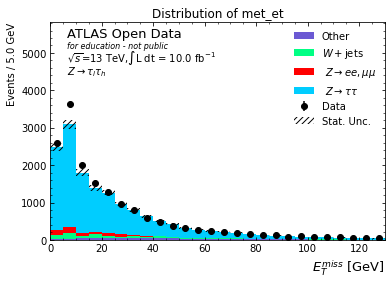

In [23]:
# 0-130 met_et
plot_variable(data, 0, 130, 'met_et')

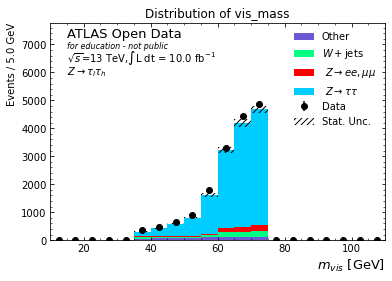

In [24]:
# 10-110 vis_mass
plot_variable(data, 10, 110, 'vis_mass')

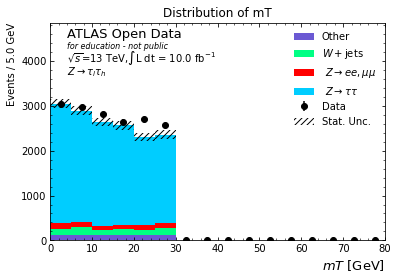

In [25]:
# 0-80 mT 
plot_variable(data, 0, 80, 'mT')